<a href="https://colab.research.google.com/github/dht7166/kaggle_save/blob/master/Denoising_Document.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 1.x
import pandas as pd
import keras
from keras import layers
from keras import models
from keras.models import Model
import numpy as np
from keras import backend as K
from keras.activations import relu
from keras.layers import Input,Conv2D,LeakyReLU,BatchNormalization,MaxPool2D,Dense
from keras.layers import UpSampling2D,Add,Concatenate,Average, ReLU, Flatten

from sklearn.model_selection import train_test_split

from keras.utils import Sequence
import random
import numpy as np
import glob
from skimage import io
from skimage import transform
from matplotlib import pyplot as plt
import os
workdir = 'drive/My Drive/kaggle_document/'

Using TensorFlow backend.


In [4]:
# Define the small autoencoder
# Describe the autoencoder
encoder_in = Input((420,540,1))

# 3 layers of conv and max-pooling
x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',name = 'conv1')(encoder_in)
x = MaxPool2D(pool_size=(2,2))(x)
x = BatchNormalization()(x) 


x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',name = 'conv3')(x)
x = BatchNormalization()(x) 


x = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',name = 'conv5')(x)
x = BatchNormalization()(x) 


x = UpSampling2D((2,2))(x)
x = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',name = 'conv7')(x)
x = BatchNormalization()(x) 

decoder_out = Conv2D(filters=1,kernel_size=(3,3),strides=(1,1),padding='same',activation='sigmoid',name = 'conv8')(x)


# Finally, combine everything together to create the autoencoder

autoencoder = Model(encoder_in,decoder_out)
opt = keras.optimizers.Adam(lr = 1e-3)
autoencoder.compile(optimizer=opt,loss = 'mse',metrics=['mse'])
autoencoder.summary()















Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 420, 540, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 210, 270, 32)      128       
_________________________________________________________________
conv3 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 210, 270, 64)      256       
_________________________________________________________________
conv5 (Conv2D)               (None, 210, 270,

In [0]:
class TrainGenerator(Sequence):
  def __init__(self,workdir,batch):
    self.batch = batch
    self.X = glob.glob(workdir + 'train/*.png')
    self.Y = glob.glob(workdir + 'train_cleaned/*.png')
    self.X.sort()
    self.Y.sort()
    self.X, self.X_valid,self.Y,self.Y_valid = train_test_split(self.X,self.Y,test_size = 0.167)
    # print(self.X)
    # print(self.Y)
    # print(self.X_valid)
    # print(self.Y_valid)
    
  def __len__(self):
    return int(np.floor(len(self.X)/self.batch))

  def __getitem__(self,idx):
    X = np.zeros((self.batch,420,540,1))
    Y = np.zeros((self.batch,420,540,1))
    for i in range(self.batch*idx, self.batch*(idx+1)):
      X[i-self.batch*idx,:,:,0] = transform.resize(io.imread(self.X[i]),(420,540))
      Y[i-self.batch*idx,:,:,0] = transform.resize(io.imread(self.Y[i]),(420,540))
    
    return X,Y

  def get_valid(self):
    X = np.zeros((len(self.X_valid),420,540,1))
    Y = np.zeros((len(self.X_valid),420,540,1))
    for i in range(len(self.X_valid)):
      X[i,:,:,0] = transform.resize(io.imread(self.X_valid[i]),(420,540))
      Y[i,:,:,0] = transform.resize(io.imread(self.Y_valid[i]),(420,540))
    return X,Y

generator = TrainGenerator(workdir,12)

In [0]:
ckpt = keras.callbacks.ModelCheckpoint(workdir+'/best_loss.h5', monitor = 'loss',save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(monitor = 'loss',patience = 10)
# autoencoder.compile(optimizer=opt,loss = 'mse',metrics=['mse'])
# autoencoder.load_weights(workdir + '/best_loss.h5')
autoencoder.fit_generator(generator,epochs = 200,validation_data=generator.get_valid(),callbacks=[ckpt,earlystop])

Epoch 1/200
9/9 [==============================] - 8s 876ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - val_loss: 0.0849 - val_mean_squared_error: 0.0849
Epoch 2/200
9/9 [==============================] - 5s 519ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - val_loss: 0.0577 - val_mean_squared_error: 0.0577
Epoch 3/200
9/9 [==============================] - 6s 646ms/step - loss: 0.0506 - mean_squared_error: 0.0506 - val_loss: 0.0430 - val_mean_squared_error: 0.0430
Epoch 4/200
9/9 [==============================] - 5s 605ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 5/200
9/9 [==============================] - 6s 614ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 6/200
9/9 [==============================] - 5s 599ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 7/200
9/9 [=================

In [0]:
autoencoder.load_weights(workdir + '/best_loss.h5')

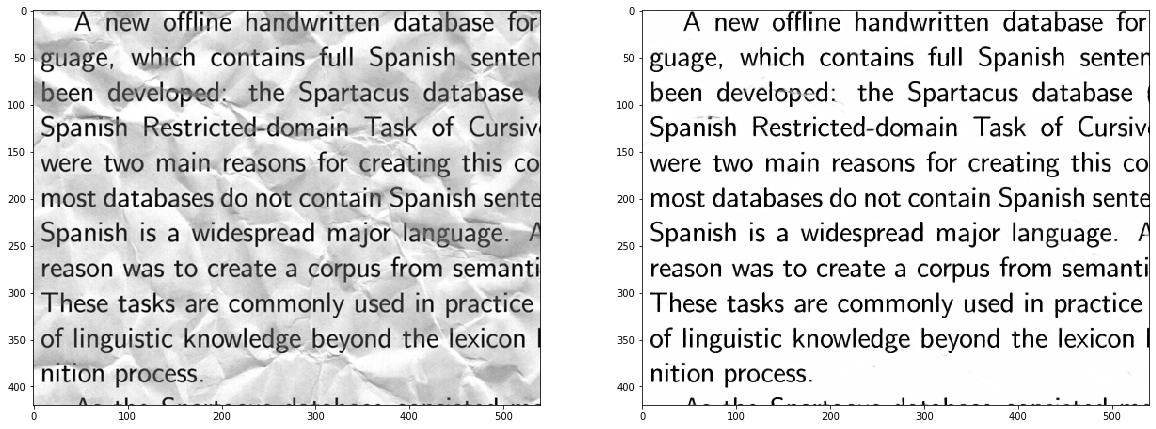

In [14]:
# Try to plot some test images
list_image = glob.glob(workdir + 'test/*.png')
list_image.sort()
image = random.choice(list_image)
image = io.imread(image)/255
og_shape = image.shape

image = transform.resize(image,(420,540))
pred = autoencoder.predict(image[np.newaxis,:,:,np.newaxis])

pred = np.squeeze(pred,axis = 0)
pred = np.squeeze(pred,axis = 2)

image = transform.resize(image,og_shape)
pred = transform.resize(pred,og_shape)

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(pred,cmap='gray')

plt.show()

In [13]:
# Write to submission file
print(workdir)
sub = open(workdir + '/submission.csv','w')
sub.write('id,value\n')
for image in list_image:
  # print(image)
  img = io.imread(image)/255
  _,img_name = os.path.split(image)
  img_name = img_name[:-4]
  og_shape = img.shape
  img = transform.resize(img,(420,540))
  img = autoencoder.predict(img[np.newaxis,:,:,np.newaxis])
  img = np.squeeze(img,axis = 0)
  img = np.squeeze(img,axis = 2)
  img = transform.resize(img,og_shape)

  for x in range(og_shape[0]):
    for y in range(og_shape[1]):
      sub.write(img_name+'_'+str(x+1)+'_'+str(y+1)+','+str(img[x][y])+'\n')
      # if x == 0 and y == 0:
      #   print((img_name+'_'+str(x+1)+'_'+str(y+1)+','+str(img[x][y])))

sub.close()


drive/My Drive/kaggle_document/
